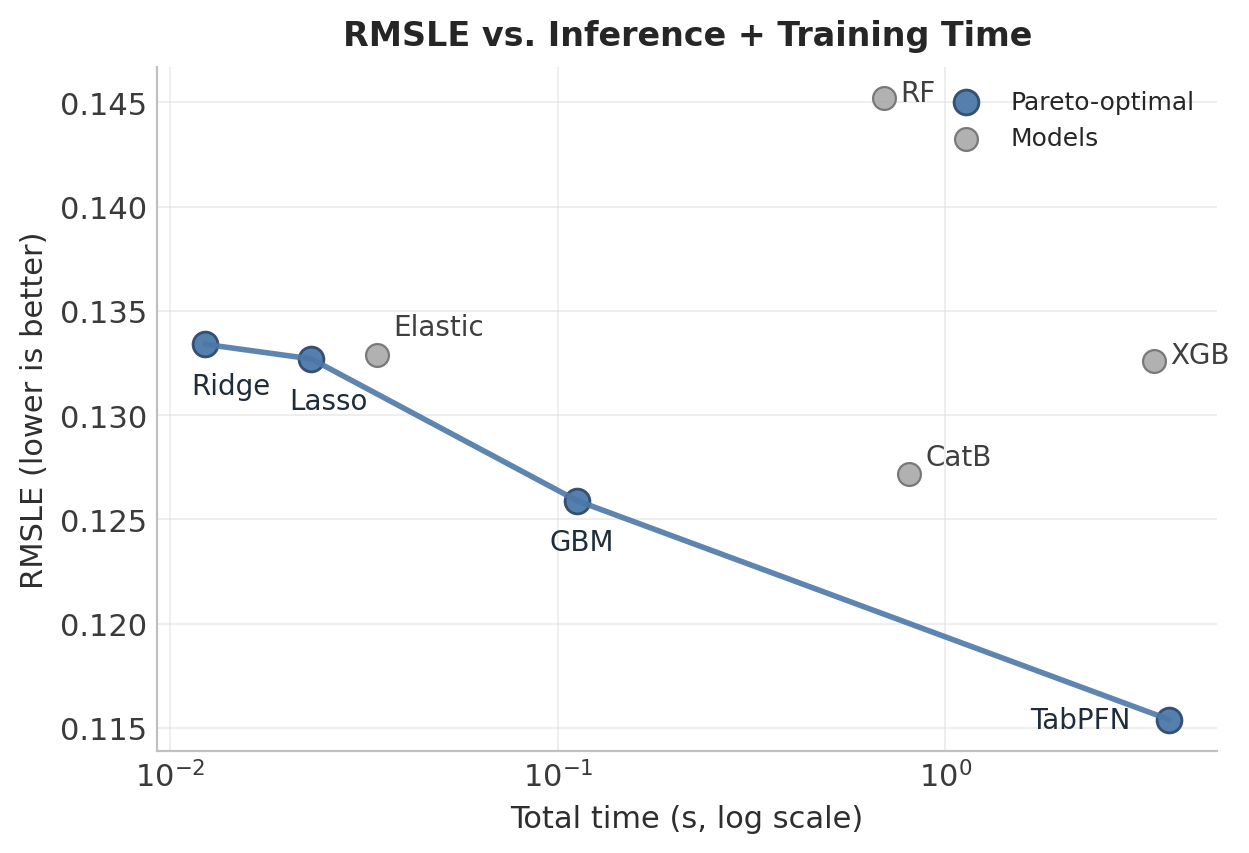

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Data (from the provided table)
# ---------------------------
raw = {
    "Lasso":   {"rmsle": 0.1327, "train": 0.0212, "infer": 0.0019},
    "Ridge":   {"rmsle": 0.1334, "train": 0.0071, "infer": 0.0052},
    "Elastic": {"rmsle": 0.1329, "train": 0.0292, "infer": 0.0049},
    "SVR":     {"rmsle": 0.4144, "train": 0.1217, "infer": 0.1877},   # outlier (excluded)
    "RF":      {"rmsle": 0.1452, "train": 0.5724, "infer": 0.1217},
    "GBM":     {"rmsle": 0.1259, "train": 0.1087, "infer": 0.0034},
    "XGB":     {"rmsle": 0.1326, "train": 3.4362, "infer": 0.0170},
    "CatB":    {"rmsle": 0.1272, "train": 0.8043, "infer": 0.0022},
    "MLP":     {"rmsle": 0.9931, "train": 3.9896, "infer": 0.0133},   # outlier (excluded)
    "TabPFN":  {"rmsle": 0.1154, "train": 2.3359, "infer": 1.4493},
}

# Remove outliers
exclude = {"MLP", "SVR"}
data = {k: v for k, v in raw.items() if k not in exclude}

# ---------------------------
# Pareto frontier (minimize inference time and RMSLE)
# ---------------------------
def pareto_frontier(points):
    # points: list of (x_infer, y_rmsle, name)
    pts = sorted(points, key=lambda t: (t[0], t[1]))  # sort by x then y
    frontier = []
    best_y = float("inf")
    for x, y, n in pts:
        if y < best_y - 1e-12:
            frontier.append((x, y, n))
            best_y = y
    return frontier

for k, v in data.items():
    total_time = v["train"] + v["infer"]
    data[k]["total"] = total_time
points = [(v["total"], v["rmsle"], k) for k, v in data.items()]
front = pareto_frontier(points)

frontier_names = {n for _, _, n in front}
non_frontier = [(x, y, n) for x, y, n in points if n not in frontier_names]

# ---------------------------
# Aesthetic style (clean, low-saturation, rounded markers)
# ---------------------------
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#C0C0C0",
    "axes.linewidth": 0.8,
    "axes.labelcolor": "#2E2E2E",
    "xtick.color": "#3A3A3A",
    "ytick.color": "#3A3A3A",
    "grid.color": "#D7D7D7",
    "grid.linewidth": 0.6,
    "grid.alpha": 0.5,
    "font.size": 11,
    "font.family": "DejaVu Sans",
})

# Palette
c_front = "#4C78A8"   # desaturated blue
c_other = "#A9A9A9"   # neutral grey
c_line  = "#4C78A8"

fig, ax = plt.subplots(figsize=(6.4, 4.4), dpi=200)

# Scatter non-frontier
if non_frontier:
    ax.scatter(
        [x for x, y, n in non_frontier],
        [y for x, y, n in non_frontier],
        s=68, c=c_other, edgecolors="#6F6F6F", linewidths=0.8, marker="o", alpha=0.9, label="Models"
    )

# Scatter frontier
ax.scatter(
    [x for x, y, n in front],
    [y for x, y, n in front],
    s=80, c=c_front, edgecolors="#2F4B6C", linewidths=1.0, marker="o", alpha=0.95, label="Pareto-optimal"
)

# Connect frontier (sorted by inference)
front_sorted = sorted(front, key=lambda t: t[0])
ax.plot(
    [x for x, y, n in front_sorted],
    [y for x, y, n in front_sorted],
    color=c_line, linewidth=2.0, alpha=0.9
)

# ---------------------------
# Manual label offsets (in points)
# - base_offset applies to all labels
# - label_offsets provides per-label fine-tuning
# Positive dx moves right; positive dy moves up.
# ---------------------------
base_offset = (0.0, 0.0)
label_offsets = {
    # Example tweaks (edit these)
    "Lasso":   (-8,  -15),
    "Ridge":   (-5, -15),
    "Elastic": (6, 10),
    "RF":      (6,  2),
    "GBM":     (-10, -15),
    "XGB":     (6,  2),
    "CatB":    (6,  6),
    "TabPFN":  (-50,  0),
}

def annotate(ax, pts, color):
    for x, y, n in pts:
        dx = base_offset[0] + label_offsets.get(n, (0, 0))[0]
        dy = base_offset[1] + label_offsets.get(n, (0, 0))[1]
        ax.annotate(
            n, xy=(x, y),
            xytext=(dx, dy),
            textcoords="offset points",
            color=color, fontsize=10,
            ha="left", va="center",
            # Removed white background (no bbox)
            clip_on=False
        )

annotate(ax, non_frontier, "#3F3F3F")
annotate(ax, front, "#1F2D3A")

# Axes, grid, labels
ax.set_xscale("log")
ax.grid(True, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("Total time (s, log scale)")
ax.set_ylabel("RMSLE (lower is better)")
ax.set_title("RMSLE vs. Inference + Training Time", pad=8, fontsize=12, weight="semibold")

# Legend
handles, labels = ax.get_legend_handles_labels()
order = [labels.index("Pareto-optimal")] + [i for i, l in enumerate(labels) if l == "Models"]
ax.legend([handles[i] for i in order], [labels[i] for i in order],
          frameon=False, loc="upper right", fontsize=9)

plt.tight_layout()
plt.savefig("pareto.png")
plt.show()